# Comparing Old vs New Multi-Step Forecasting Strategies

This notebook compares the performance of "old" (classic) multi-step forecasting strategies against "new" (stratified) strategies.
All core logic is imported from `oldvsnew_utility.py` for clarity and maintainability.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from oldvsnew_utility import generate_vectors, vector_to_strategy_name, strategy_p, name_strategy_p, sample_performance, simulate
from tqdm import tqdm

## Load Results Data
We load the results produced by running the main experiment script (e.g., `example.py`). These include validation and test statistics for all strategies.


In [ ]:
import os

# Define default values as variables
dataset_name = 'ExchangeRate'
func = 'MLP'
metric = 'mse'
verbose = True
H_ahead = 10
window_ratio = 2
train_p = 0.8
val_p = 0.1
test_p = 0.1
epochs = 1000
window_size = 160
seed = 1
tiny = False
strategies = 'r,d,s'
# Construct the command using f-strings
cmd = [
    "python", "example.py",
    f"--dataset_name={dataset_name}",
    f"--func={func}",
    f"--metric={metric}",
    f"--verbose={verbose}",
    f"--H_ahead={H_ahead}",
    f"--window_ratio={window_ratio}",
    f"--train_p={train_p}",
    f"--val_p={val_p}",
    f"--test_p={test_p}",
    f"--epochs={epochs}",
    f"--seed={seed}",
    f"--tiny={tiny}",
    f"--strategies={strategies}"
]
if window_size is None:
    window_size = int(H_ahead * window_ratio)
# Only include window_size if it's not None
if window_size is not None:
    cmd.append(f"--window_size={window_size}")

import subprocess
# result = subprocess.run(cmd, capture_output=True, text=True)
# Print the output
# print(result.stdout)

from forecasting_functions import torch_simple_MLP, torch_simple_RNN, torch_simple_LSTM, torch_simple_Transformer
if func == 'MLP':
    forecasting_function = torch_simple_MLP(128, epochs=epochs)
if func == 'RNN':
    forecasting_function = torch_simple_RNN(128, epochs=epochs)
if func == 'LSTM':
    forecasting_function = torch_simple_LSTM(128, epochs=epochs)
if func == 'Transformer':
    forecasting_function = torch_simple_Transformer(128, epochs=epochs)
rel_directory = dataset_name + '/' + forecasting_function.name + f'_seed{seed}' + '/'
if tiny:
    rel_directory = f'tiny_{dataset_name}' + '/' + forecasting_function.name + f'_seed{seed}' + '/'

if tiny :
    settings = f'tiny_h_{H_ahead}_w_{window_size}'
else:
    settings = f'h_{H_ahead}_w_{window_size}_t_{train_p}'
if tiny:
    save_folder = 'tiny_stratify_rerun_results/' + rel_directory + settings + '/'
else:
    # save_folder = 'stratify_rerun_results/' + rel_directory + settings + '/'
    # save_folder = 'stratify_rerun_results_bp_offline/' + rel_directory + settings + '/'
    save_folder = 'stratify_rerun_results_bp2/' + rel_directory + settings + '/'

# print what is in save_folder
print(os.listdir(save_folder))

['train_stats.csv', 'val_predictions', 'train_predictions', 'fit_times.csv', 'test_predictions', 'val_stats.csv', 'test_stats.csv']


In [3]:
# load train and val stats.csv
import pandas as pd 
train_stats = pd.read_csv(save_folder + 'train_stats.csv', index_col = 0)
val_stats = pd.read_csv(save_folder + 'val_stats.csv', index_col = 0)
test_stats = pd.read_csv(save_folder + 'test_stats.csv', index_col = 0)
# collapse train_stats over the multiindex 'horizon', preserving the strategy index
train_stats_hmean = train_stats.groupby(['strategy', 'horizon']).mean()
train_stats_hmean = train_stats_hmean.groupby('strategy').mean()
val_stats_hmean = val_stats.groupby(['strategy', 'horizon']).mean()
val_stats_hmean = val_stats_hmean.groupby('strategy').mean()
test_stats_hmean = test_stats.groupby(['strategy', 'horizon']).mean()
test_stats_hmean = test_stats_hmean.groupby('strategy').mean()


train_time_df = pd.read_csv(save_folder + 'fit_times.csv')
train_time_df = train_time_df.rename(columns={'Unnamed: 0': 'strategy'})
train_time_df.index = train_time_df['strategy']
train_time_df = train_time_df.drop(columns=['strategy'])


train_stats = train_stats_hmean
val_stats = val_stats_hmean
test_stats = test_stats_hmean

print('Loaded stats:', val_stats.shape, test_stats.shape)

if train_time_df.loc['stratifyDIRMO_1_RECMO_1']['fit_time'] < train_time_df.loc['DIRMO_1']['fit_time']:
    weights_shared = True
else:
    weights_shared = False
print(f'Using shared weights: {weights_shared}')

Loaded stats: (58, 7) (58, 7)
Using shared weights: True


## Identify Old vs New Strategies
Old strategies are those without 'stratify' in their name (except for 'stratifyRECMO_1_DIRMO_1' which is rectify). New strategies contain 'stratify' in their name.


In [4]:
all_strategies = val_stats.index.unique().tolist()
all_strategies = [s for s in all_strategies if 'ensemble' not in s]
old_strategies = [s for s in all_strategies if 'stratify' not in s or s == 'stratifyRECMO_1_DIRMO_1']
new_strategies = [s for s in all_strategies if s not in old_strategies]
print(f'Old strategies: {len(old_strategies)}\nNew strategies: {len(new_strategies)}')
print(old_strategies)
print(new_strategies)

Old strategies: 8
New strategies: 48
['DIRMO_1', 'DIRMO_2', 'DIRMO_5', 'RECMO_1', 'RECMO_10', 'RECMO_2', 'RECMO_5', 'stratifyRECMO_1_DIRMO_1']
['stratifyDIRMO_1_DIRMO_1', 'stratifyDIRMO_1_DIRMO_2', 'stratifyDIRMO_1_DIRMO_5', 'stratifyDIRMO_1_RECMO_1', 'stratifyDIRMO_1_RECMO_10', 'stratifyDIRMO_1_RECMO_2', 'stratifyDIRMO_1_RECMO_5', 'stratifyDIRMO_2_DIRMO_1', 'stratifyDIRMO_2_DIRMO_2', 'stratifyDIRMO_2_DIRMO_5', 'stratifyDIRMO_2_RECMO_1', 'stratifyDIRMO_2_RECMO_10', 'stratifyDIRMO_2_RECMO_2', 'stratifyDIRMO_2_RECMO_5', 'stratifyDIRMO_5_DIRMO_1', 'stratifyDIRMO_5_DIRMO_2', 'stratifyDIRMO_5_DIRMO_5', 'stratifyDIRMO_5_RECMO_1', 'stratifyDIRMO_5_RECMO_10', 'stratifyDIRMO_5_RECMO_2', 'stratifyDIRMO_5_RECMO_5', 'stratifyRECMO_10_DIRMO_1', 'stratifyRECMO_10_DIRMO_2', 'stratifyRECMO_10_DIRMO_5', 'stratifyRECMO_10_RECMO_1', 'stratifyRECMO_10_RECMO_10', 'stratifyRECMO_10_RECMO_2', 'stratifyRECMO_10_RECMO_5', 'stratifyRECMO_1_DIRMO_2', 'stratifyRECMO_1_DIRMO_5', 'stratifyRECMO_1_RECMO_1', 'stratif

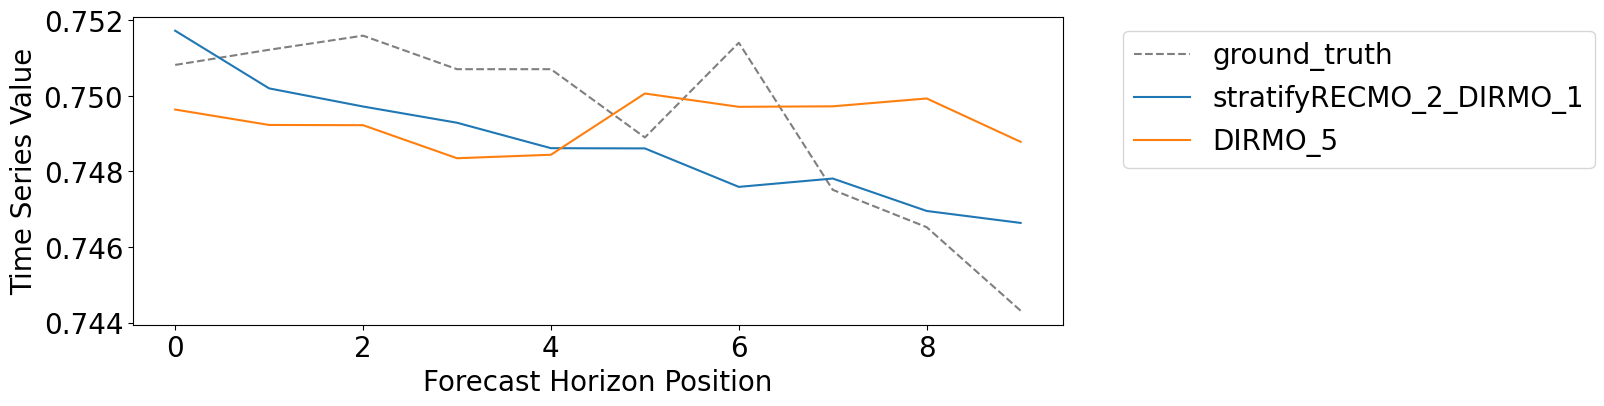

In [7]:
outputs_df = pd.read_csv(save_folder + 'test_predictions/outputs_0.csv')
outputs_df.index = outputs_df['strategy']
outputs_df = outputs_df.drop(columns=['strategy'])  
ground_truth = outputs_df.loc['ground_truth']

# get the best new strategy
best_new_strategy = test_stats.loc[new_strategies]['mean'].idxmin()
best_old_strategy = test_stats.loc[old_strategies]['mean'].idxmin()

plt.rcParams.update({'font.size': 20})
# axes ticks and labels too
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.figure(figsize=(12, 4))
plt.plot(ground_truth.values, label='ground_truth', c = 'k', alpha=0.5, linestyle='--')
plt.plot(outputs_df.loc[best_new_strategy].values, label=best_new_strategy)
plt.plot(outputs_df.loc[best_old_strategy].values, label=best_old_strategy)
plt.xlabel('Forecast Horizon Position')
plt.ylabel('Time Series Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('sanitycheck.pdf', bbox_inches='tight', dpi=300)
plt.show() 


## Compare Performance: Best of Old vs Best of New
For each group, we find the best (lowest error) strategy on the test set.
This is what is done in the Stratify paper.

In [8]:
best_new_error = test_stats.loc[new_strategies]['mean'].min()
best_old_error = test_stats.loc[old_strategies]['mean'].min()
print(f'Best new strategy test error: {best_new_error}')
print(f'Best old strategy test error: {best_old_error}')
print(f'Ratio new/old: {best_new_error/best_old_error}')
# add how many new beat the best old
ratio = np.sum(test_stats.loc[new_strategies]['mean'] < best_old_error)/len(new_strategies)
print(f'{ratio * 100}% of new strategies beat the best old strategy')

Best new strategy test error: 5.980220176550746e-05
Best old strategy test error: 6.445284146306837e-05
Ratio new/old: 0.927844303028506
25.0% of new strategies beat the best old strategy


## Simulate Random Sampling
Suppose we randomly sample $n$ strategies from each group and select the best on validation, then report its test error. We repeat this $R$ times for robustness.
This can simulate a more realistic setting where we do not know the true best strategy and search for it under some compute budget.

In [9]:
# set seed
np.random.seed(42)

n_sampled_strategies = 1
R = 1000
old_stats, new_stats, _, _ = simulate(n_sampled_strategies, val_stats, test_stats, old_strategies, new_strategies, R=R, weights_shared = weights_shared)
print(f'Mean test error (old): {old_stats.mean()}')
print(f'Mean test error (new): {new_stats.mean()}')
# print ratio
print(f'Old error reduction ratio: {new_stats.mean() / old_stats.mean()}')


Mean test error (old): 0.00023824910457286412
Mean test error (new): 0.00014625497542396023
Old error reduction ratio: 0.6138741872132863


## Visualize Results
Boxplots comparing the distribution of test errors for old vs new strategies after random sampling.


/var/folders/96/zy_ybtm95qb0cnjt5fk0g3j40000gp/T/ipykernel_55300/4008947275.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot([old_stats, new_stats], labels=['Existing \n Strategies', 'Novel-Only\n Stratify Strategies'], showmeans=False)


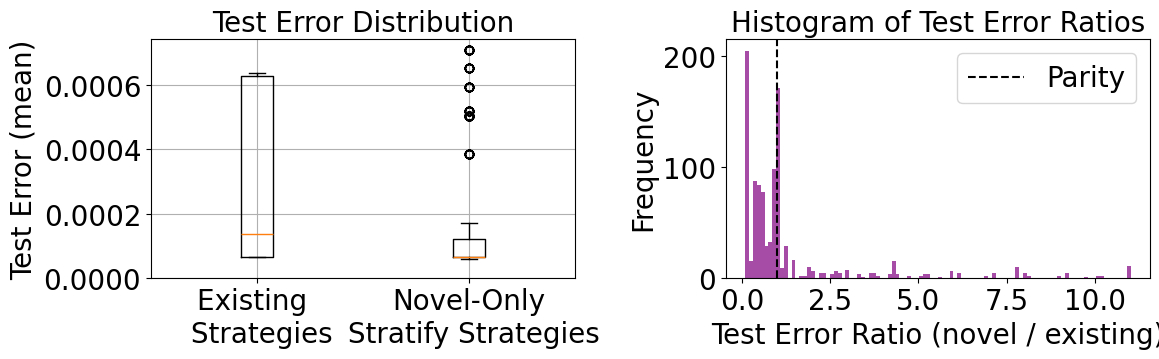

One-sample t-test vs 1: t=4.55, p=6.04e-06


In [10]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

ratios = new_stats / old_stats

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# make fonts bigger on plot
plt.rcParams.update({'font.size': 20})
# axes ticks and labels too
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# Boxplot of old vs new
axs[0].boxplot([old_stats, new_stats], labels=['Existing \n Strategies', 'Novel-Only\n Stratify Strategies'], showmeans=False)
axs[0].set_ylabel('Test Error (mean)')
axs[0].set_title('Test Error Distribution')
axs[0].grid(True)

# Histogram of ratios
axs[1].hist(ratios, bins=100, alpha=0.7, color='purple')
axs[1].set_xlabel('Test Error Ratio (novel / existing)')
axs[1].set_ylabel('Frequency')
axs[1].axvline(1, color='k', linestyle='--', label='Parity')
axs[1].legend()
axs[1].set_title('Histogram of Test Error Ratios')

axs[0].set_ylim(0,None)
# axs[1].set_ylim(0,None)
plt.tight_layout()
plt.savefig('test_error_ratio.pdf', dpi=300)
plt.show()

# Statistical test: one-sample t-test vs 1 (parity)
t_stat, p_val = ttest_1samp(ratios, popmean=1)
print(f'One-sample t-test vs 1: t={t_stat:.2f}, p={p_val:.4g}')


Now let's plot a graph to see how utilising the Stratify space depends on the number of strategies you sample.

100%|██████████| 48/48 [00:53<00:00,  1.11s/it]


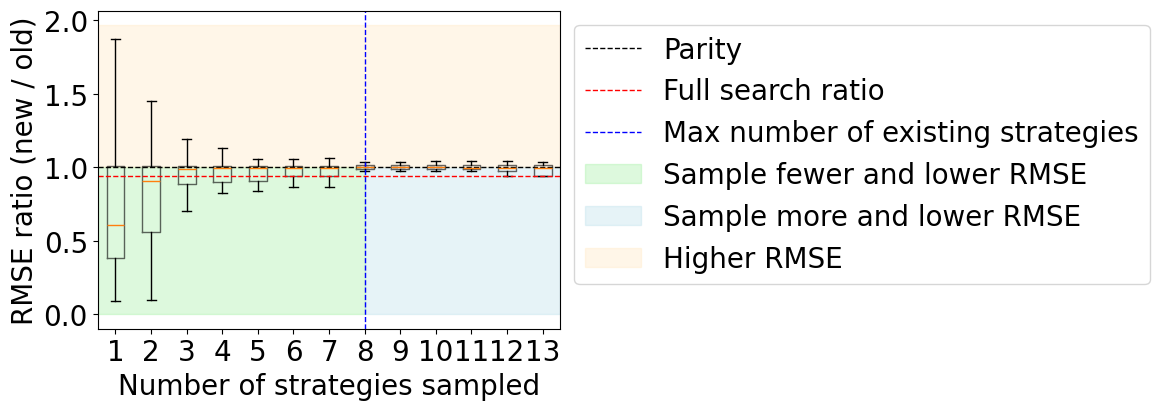

In [11]:
# flip so less than 1 is better

# ------------------------------------------------------------------
# Monte-Carlo settings
# ------------------------------------------------------------------
R        = 1_000
max_n    = min(len(new_strategies), 50)
ratio_by_n = []          # list of length max_n; each item is (R,) array
old_times_list = []
new_times_list = []
for n in tqdm(range(1, max_n + 1)):
    old_stats, new_stats, old_times, new_times = simulate(
        n, val_stats_hmean, test_stats_hmean,
        old_strategies, new_strategies, R=R, stat=np.min, time_df = train_time_df, weights_shared = weights_shared
    )          
    ratios =  new_stats/old_stats              # <1 ⇒ new better
    ratio_by_n.append(ratios)
    old_times_list.append(old_times)
    new_times_list.append(new_times)
final_ratio = np.mean(ratio_by_n[-1])

# ------------------------------------------------------------------
# make 

parity = 1.0
x_split = len(old_strategies)

fig, ax = plt.subplots(figsize=(1.5*len(old_strategies), 4.5))         # width scales with n
x_positions = np.arange(1, len(old_strategies) + 1 + 5)



parts = ax.boxplot(
    ratio_by_n[:len(x_positions)],
    positions=x_positions,
    showmeans=False, showfliers=False
)

# Cosmetic tweaks
for pc in parts['boxes']:
    pc.set_alpha(0.6)
ax.axhline(1, color='k', linestyle='--', linewidth=1, label='Parity')  # parity line
ax.axhline(final_ratio, color='r', linestyle='--', linewidth=1, label='Full search ratio')

# vertiel line at x = len(old_strategies) + 1 
ax.axvline(x_split, color='b', linestyle='--', linewidth=1, label='Max number of existing strategies')


# Light green: Below parity and left of vertical line
ax.axhspan(0, parity, xmin=0, xmax=(x_split-0.5) / len(x_positions), color='lightgreen', alpha=0.3, label='Sample fewer and lower RMSE')

# Light blue: Below parity and right of vertical line
ax.axhspan(0, parity, xmin=(x_split-0.5) / len(x_positions), xmax=1, color='lightblue', alpha=0.3, label='Sample more and lower RMSE')

# Light orange: Above parity (across full x-range)
ax.axhspan(parity, ax.get_ylim()[1], xmin=0, xmax=1, color='moccasin', alpha=0.3, label='Higher RMSE')


ax.set_xlabel('Number of strategies sampled')
ax.set_ylabel('RMSE ratio (new / old)')

ax.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.savefig('sampling_line.pdf', dpi=300)
plt.show()

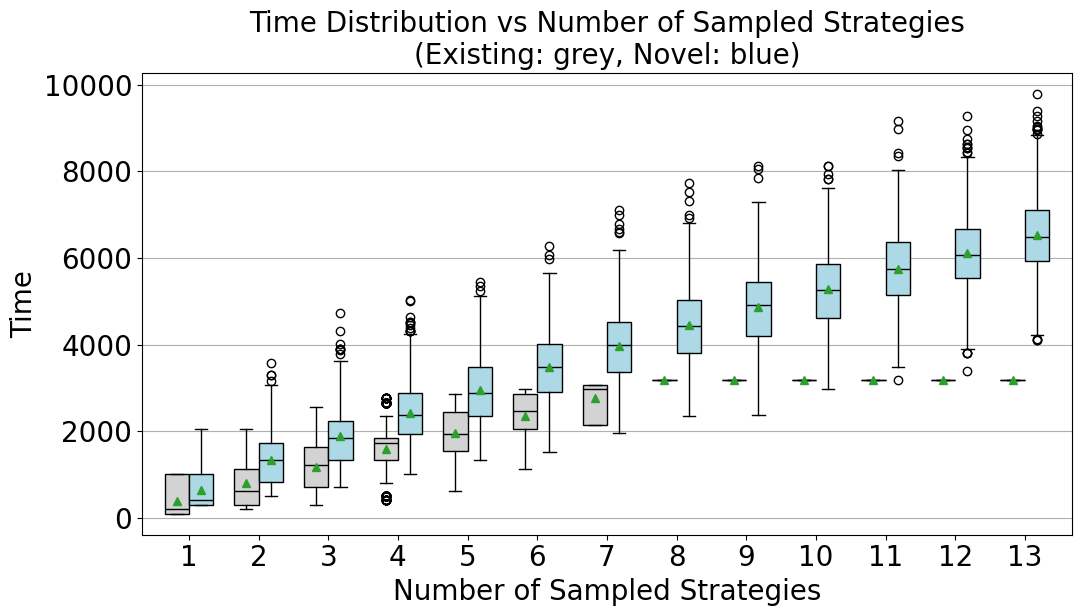

In [12]:
plt.figure(figsize=(12, 6))
positions = x_positions
width = 0.35

for i in range(len(x_positions)):
    plt.boxplot(old_times_list[i], positions=[positions[i] - width/2], widths=width, patch_artist=True, boxprops=dict(facecolor='lightgrey'), medianprops=dict(color="black"), showmeans = True)
    plt.boxplot(new_times_list[i], positions=[positions[i] + width/2], widths=width, patch_artist=True, boxprops=dict(facecolor='lightblue'), medianprops=dict(color="black"), showmeans = True)

plt.xticks(positions, x_positions)
plt.xlabel('Number of Sampled Strategies')
plt.ylabel('Time')
plt.title('Time Distribution vs Number of Sampled Strategies\n(Existing: grey, Novel: blue)')
plt.grid(True, axis='y')
plt.show()

New gradient: 506.82920577128726
Old gradient: 424.4713576180594
Gradient ratio: 1.1940245123142883


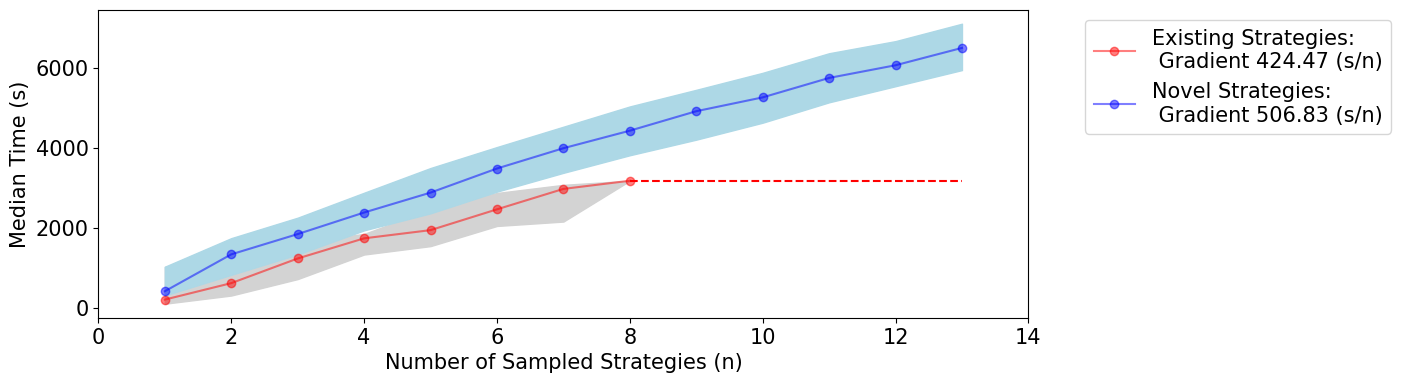

In [13]:
extend = 5
median_old_times = [np.median(x) for x in old_times_list[:len(old_strategies)]]
median_new_times = [np.median(x) for x in new_times_list[:len(old_strategies) + extend]]
upper_quartile_old_times = [np.percentile(x, 75) for x in old_times_list[:len(old_strategies)]]
upper_quartile_new_times = [np.percentile(x, 75) for x in new_times_list[:len(old_strategies) + extend]]
lower_quartile_old_times = [np.percentile(x, 25) for x in old_times_list[:len(old_strategies)]]
lower_quartile_new_times = [np.percentile(x, 25) for x in new_times_list[:len(old_strategies) + extend]]
# plot lines and then compute gradient of each and add to labels
new_gradient = np.diff(median_new_times).mean()
old_gradient = np.diff(median_old_times).mean()
print(f"New gradient: {new_gradient}")
print(f"Old gradient: {old_gradient}")
# ratio of gradients
gradient_ratio = new_gradient / old_gradient
print(f"Gradient ratio: {gradient_ratio}")
# plot lines
x_positions = np.arange(1, len(median_old_times)+1)
x_positions_new = np.arange(1, len(old_strategies)+extend+1)


# size of legend font
plt.rcParams.update({'font.size': 15})
# size of axis labels
plt.rcParams.update({'axes.labelsize': 15})
# size of tick labels
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize': 15})


plt.figure(figsize=(12, 4))
plt.plot(x_positions, median_old_times, 'ro-', label=f"Existing Strategies:\n Gradient {old_gradient:.2f} (s/n)", alpha=0.5)
plt.plot(x_positions_new, median_new_times, 'bo-', label=f"Novel Strategies:\n Gradient {new_gradient:.2f} (s/n)", alpha=0.5)
plt.fill_between(x_positions, lower_quartile_old_times, upper_quartile_old_times, color='lightgrey')
plt.fill_between(x_positions_new, lower_quartile_new_times, upper_quartile_new_times, color='lightblue')
# add a horizonal line from where the old methods end to the end of the new methods
plt.hlines(median_old_times[-1], x_positions[-1], x_positions_new[-1], colors='r', linestyles='--')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, len(x_positions_new)+1)
plt.xlabel("Number of Sampled Strategies (n)")
plt.ylabel("Median Time (s)")
plt.savefig("old_vs_new_compute_time.pdf", bbox_inches='tight')
plt.show()

100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


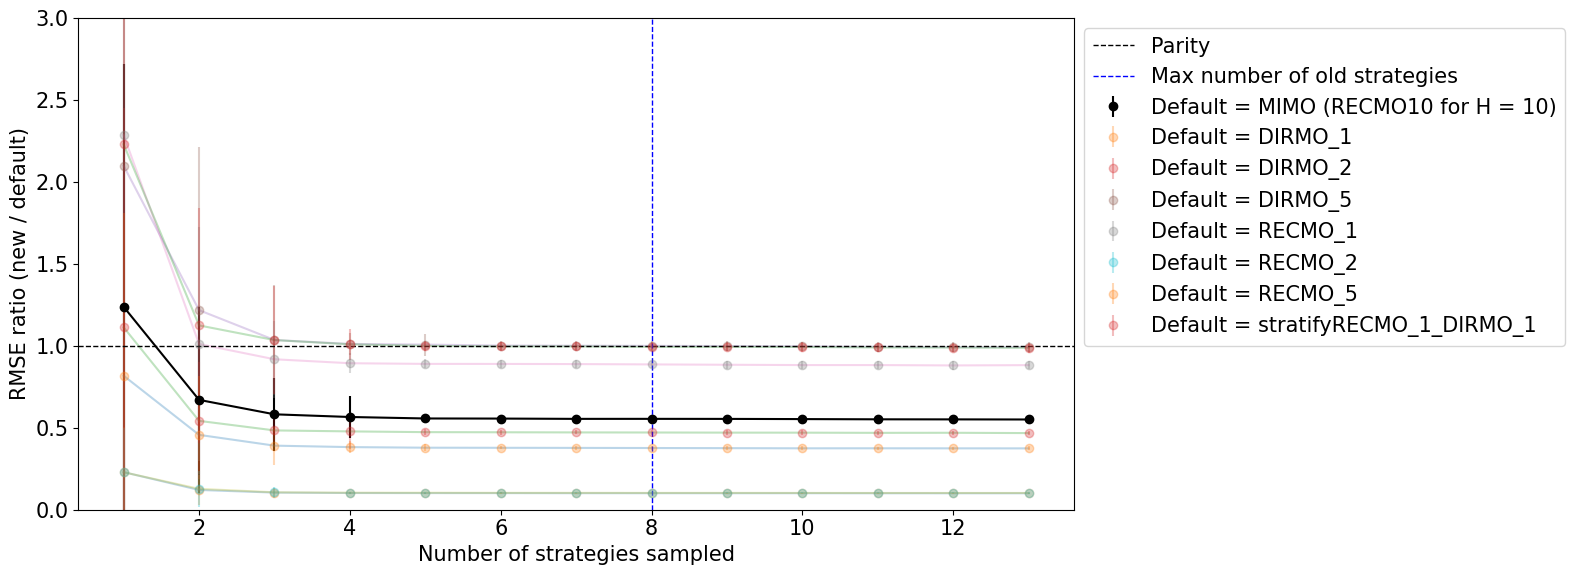

In [14]:
# compare to the default
default_strategy = f'RECMO_{H_ahead}'
curve_dict = {}
for default_strategy in old_strategies:
    default_strategy_p = test_stats_hmean.loc[default_strategy]['mean']
    # ------------------------------------------------------------------
    # Monte-Carlo settings
    # ------------------------------------------------------------------

    R        = 1_000
    max_n    = min(len(new_strategies), 13)

    ratio_by_n_new = []          # list of length max_n; each item is (R,) array
    ratio_by_n_old = []
    for n in tqdm(range(1, max_n + 1)):
        old_stats, new_stats, _, _ = simulate(
            n, val_stats_hmean, test_stats_hmean,
            old_strategies, new_strategies, R=R, stat=np.min, time_df = train_time_df, weights_shared = weights_shared
        )          
        ratios_new =  new_stats/default_strategy_p              # <1 ⇒ new better
        ratios_old = old_stats/default_strategy_p
        ratio_by_n_new.append(ratios_new)
        ratio_by_n_old.append(ratios_old)
    means = [np.mean(x) for x in ratio_by_n_new]
    medians = [np.median(x) for x in ratio_by_n_new]
    uppers = [np.percentile(x, 75) for x in ratio_by_n_new]
    lowers = [np.percentile(x, 25) for x in ratio_by_n_new]
    stds = [np.std(x) for x in ratio_by_n_new]
    curve_dict[default_strategy] = {
        'means': means,
        'medians': medians,
        'uppers': uppers,
        'lowers': lowers,
        'stds': stds
    }

fig, ax = plt.subplots(figsize=(2*len(old_strategies), 6))         # width scales with n
x_positions = np.arange(1,1+len(old_strategies)+5)

# organise curve_dict so that the MIMO line is the first one
from collections import OrderedDict

mimo_key = f'RECMO_{H_ahead}'
ordered_keys = [mimo_key] + [k for k in curve_dict if k != mimo_key]
curve_dict = OrderedDict((k, curve_dict[k]) for k in ordered_keys)


# plot the dict
for key, value in curve_dict.items():
    alpha = 0.3
    c = None
    if key == f'RECMO_{H_ahead}':
        alpha = 1
        c = 'k'
        key = f'MIMO (RECMO{H_ahead} for H = 10)'
    ax.plot(x_positions, value['means'], alpha=alpha, c=c)
    # ax.fill_between(x_positions, value['lowers'], value['uppers'], alpha=0.2, c=c)
    ax.errorbar(x_positions, value['means'], yerr=value['stds'], fmt='o', alpha=alpha, c=c, label=f'Default = {key}')


# Cosmetic tweaks
ax.axhline(1, color='k', linestyle='--', linewidth=1, label='Parity')  # parity line
# vline at x = len(old_strategies) + 1
ax.axvline(len(old_strategies), color='b', linestyle='--', linewidth=1, label='Max number of old strategies')

ax.set_xlabel('Number of strategies sampled')
ax.set_ylabel('RMSE ratio (new / default)')
# ax.set_title('Sampling New vs a Default Strategy')
# ax.set_xticks(x_positions[::max(1, max_n//10)])         # reduce tick crowding

ax.set_ylim(0, 3)
ax.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
# plt.yscale('log')
plt.savefig(f'default_vs_new.pdf', bbox_inches='tight', dpi=300)
plt.show()